# DC Resistivity Part 1

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines a model similar to that analyzed in [Kaufman (1990)](https://doi.org/10.1190/1.1442769). Here, we look at the DC electric field, current density, and charge distributions along the well near a source. We show the behaviour in the near and intermediate zones as defined in [Kaufman (1990)](https://doi.org/10.1190/1.1442769).

This notebook was used to produce Figure 5 in Heagy and Oldenburg (2018).  

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
import ipywidgets

# finite volume 
import discretize
from discretize import utils

# numerical simulation
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

# solver
from pymatsolver import Pardiso

# wrappers specific to solving casing problems
import casingSimulations as casingSim

%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14

##  Simulation Parameters

Here, we set a simulation directory where we can save the results and set the other main parameters for the example including the casing length and the conductivity of the background

In [4]:
simDir = 'DC_Kaufman'  # create a simulation directory where results can be saved. 

In [5]:
# casing parameters 
casing_l = 2000 # 2km long casing
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

sigma_back=1e-2 # 100 Ohm-background
sigma_casing=1e6  # conductivity of the casing

In [6]:
print(
    'The casing is {}m long, and the '
    'conductivity of the background is {} S/m'.format(
        casing_l, sigma_back
    )
)

The casing is 2000m long, and the conductivity of the background is 0.01 S/m


We set up 2 models, 
- `model` includes the conductive, steel cased well
- `wholespace` does not include a conductive well, it is a wholespace with conductivity 0.01S/m

In [7]:
# an object for convienently storing the model parameters
model = casingSim.model.CasingInWholespace(
    directory = simDir,
    sigma_casing = sigma_casing,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    casing_d = casing_d-casing_t,  # 10c.m is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., 0., -casing_l/2.],  # put the A electrode just below the surface
    src_b = np.r_[casing_l, 0., -casing_l/2.] # put the return electrode at a distance of 2 x length of well away
)

In [8]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{u'__class__': 'CasingInWholespace',
 'casing_d': 0.09000000000000001,
 'casing_l': 2000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': u'DC_Kaufman',
 'filename': u'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_back': 0.01,
 'sigma_casing': 1000000.0,
 'sigma_inside': 0.01,
 'src_a': [0.0, 0.0, -1000.0],
 'src_b': [2000.0, 0.0, -1000.0],
 'version': u'0.0.5'}

In [9]:
# copy the model and set the conductivity equal to the background so we have a baseline response to compare to
wholespace = model.copy()
wholespace.sigma_casing = wholespace.sigma_back

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [10]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 0.1  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 12, 28  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

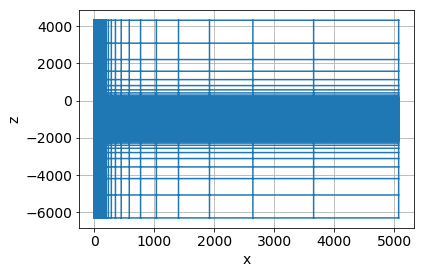

In [11]:
ax = cylMeshGen.mesh.plotGrid()

# uncomment the following to zoom in radially
# ax.set_xlim([0, 0.1])

## Put the physical properties on the mesh

Here, we organize models in a dictionary, fro there, we build the physical properties, which describes the conductivity over the entire simulation domain. 

In [12]:
# put the models in a dictionary for convienence 
model_names = ['background', 'casing']
modelDict = dict(zip(model_names, [wholespace, model]))

In [13]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(cylMeshGen, mod) 
    for name, mod in modelDict.items()
}

### Plot the models

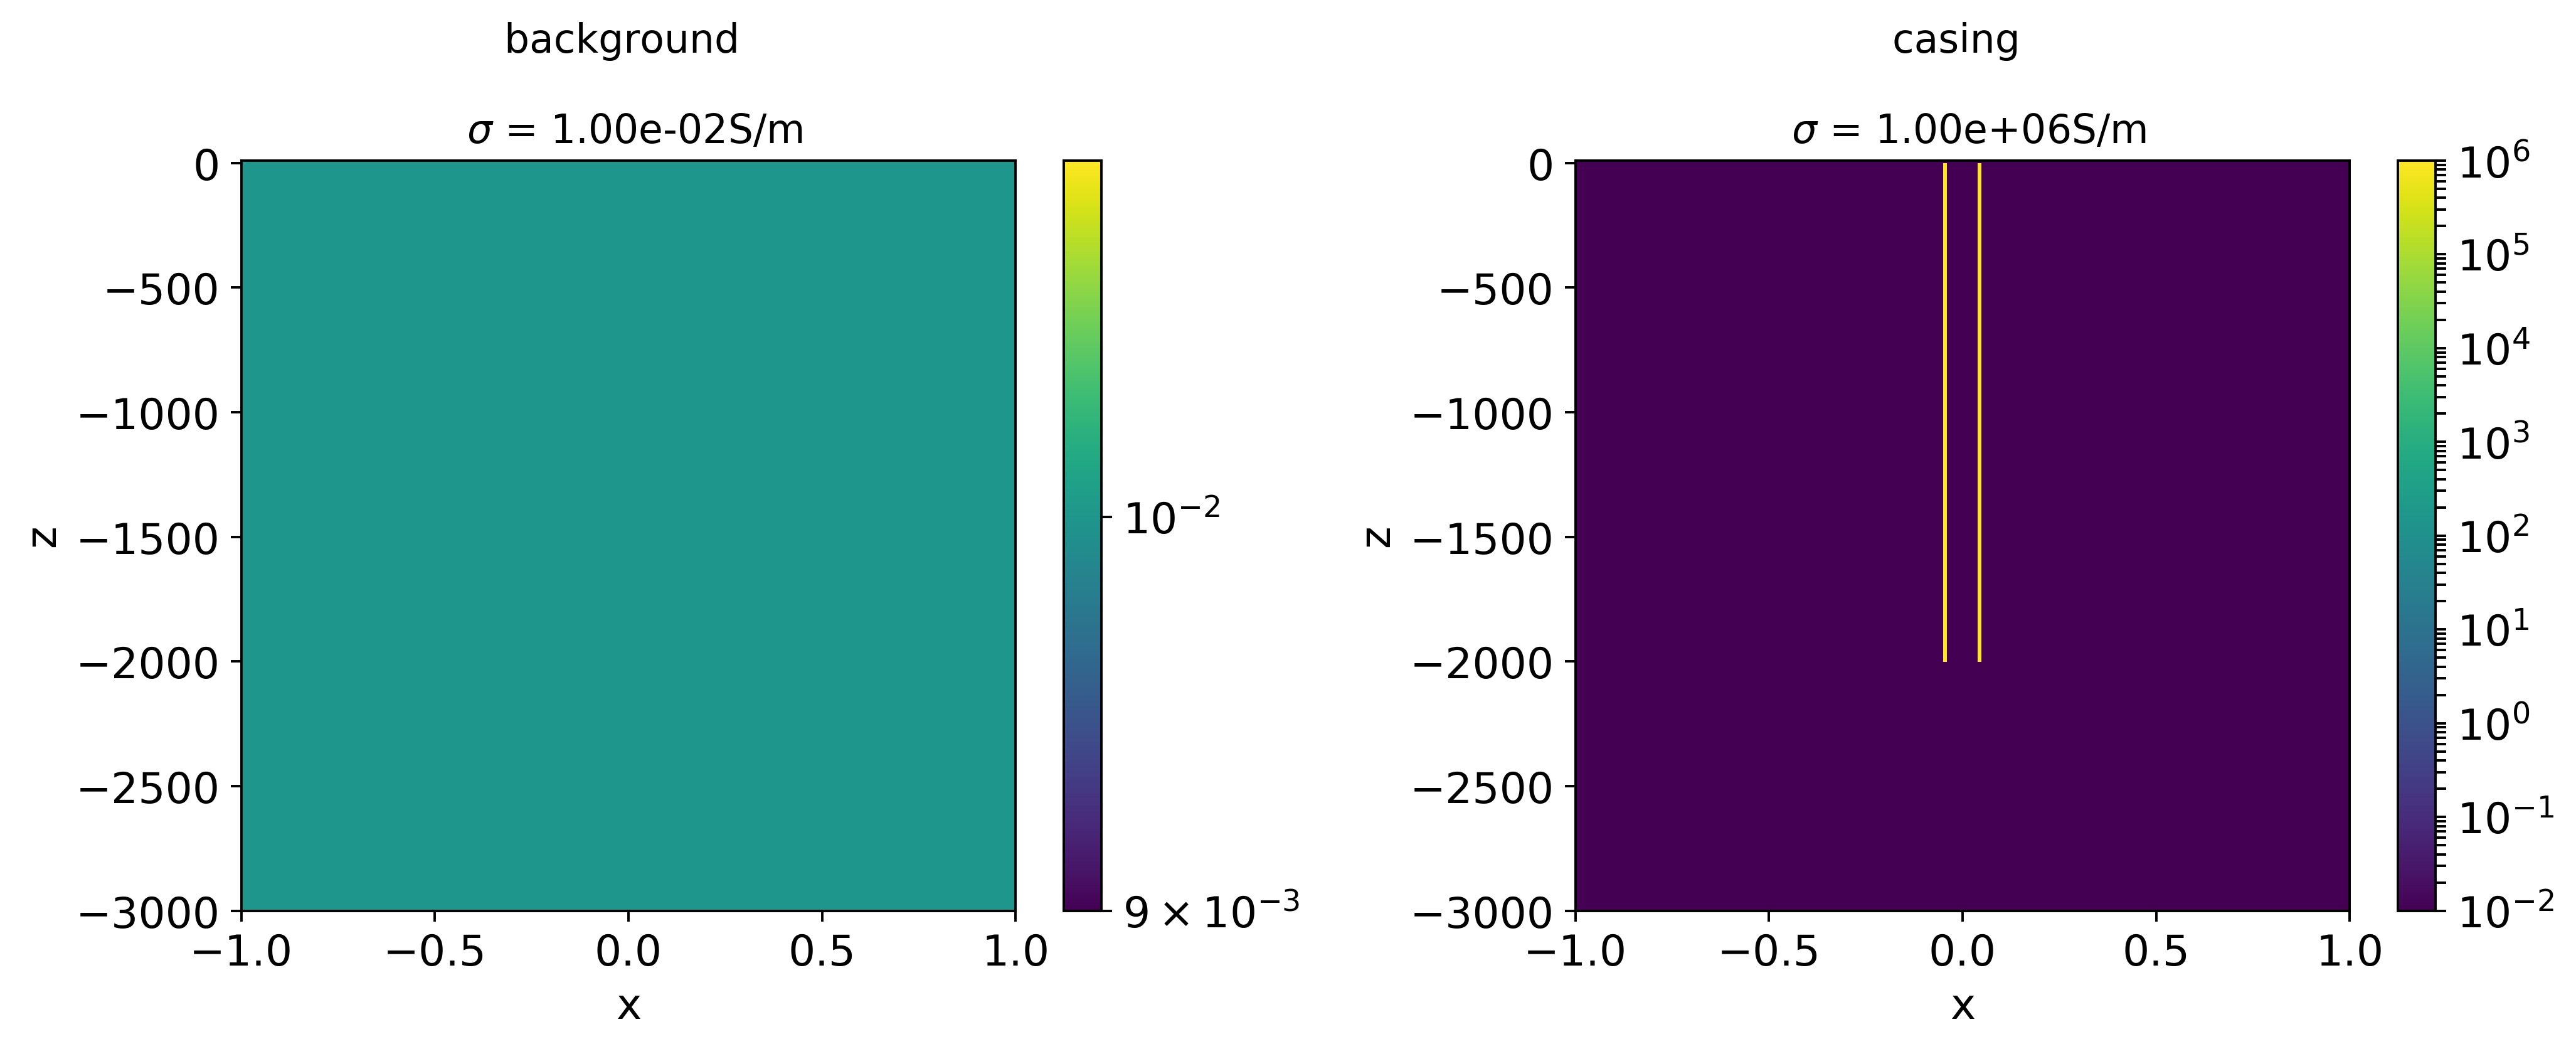

In [14]:
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

plt.tight_layout()

Text(0.055,-1000,u'source')

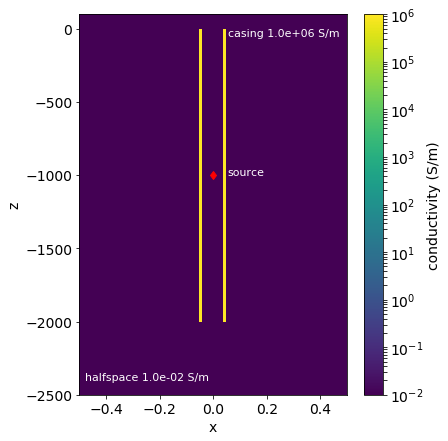

In [15]:
# Plot the source location

symbols = ['rd', 'ws', 'k>', 'mo', 'c*', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(6, 7))

# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
ax, cb = physpropsDict['casing'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
)

cb.set_label('conductivity (S/m)')

ax.set_title('')

# plot the source location
ax.plot(model.src_a[0], model.src_a[2], symbols[0])
ax.plot(model.src_b[0], model.src_b[2], symbols[0])

# set bounds
ax.set_xlim(0.5*np.r_[-1, 1]) #src_b[:, 0].max()])
ax.set_ylim([ -1.25*model.casing_l, 100])

xtext = -0.48
ax.annotate('casing {:1.1e} S/m'.format(model.sigma_casing), xy=(0.055, -50), color='w', fontsize=11)
ax.annotate('halfspace {:1.1e} S/m'.format(model.sigma_back), xy=(xtext, -1.2*model.casing_l), color='w', fontsize=11)
ax.annotate(
    'source', xy=(0.055, model.src_a[2]), color='w', fontsize=11, 
)

## set up a DC simulation

In [16]:
simDict = {}  # store the simulations in a dictionary
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, 
        src_a=modelDict[title].src_a, src_b=modelDict[title].src_b
    )

Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


## run the DC simulation

In [17]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run(save=False)
    print('\n')

--- Running background ---
Validating parameters...
      max x: 5073.21733284, min z: -6321.83434919, max z: 4321.8343492, nC: 1464818
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 10.6680400372


--- Running casing ---
Validating parameters...
      max x: 5073.21733284, min z: -6321.83434919, max z: 4321.8343492, nC: 1464818
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 9.25897312164


CPU times: user 23 s, sys: 3.65 s, total: 26.7 s
Wall time: 19.9 s


## View Fields, Fluxes, and Charges

This is a widget for interrogating the results. 
- `max_r`: maximum radial extent of the plot (m)
- `min_depth`: minimum depth (m)
- `max_depth`: maximum depth (m)
- `clim_min`: minimum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `clim_max`: maximum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `model_key`: model which we are viewing
- `view`: field or physical property that is plotted
- `prim_sec`: `primary` plots the background, `secondary` subtracts the `primary` response from the current value (note that if you select `background` and `secondary` the value will be zero and an error thrown
- `show_mesh`: if checked, the mesh will be plotted on the right hand half of the plot
- `casing_outline`: draws the outline of the casing

In [18]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names, primary_key="background"
)

In [19]:
viewer.widget_cross_section(
    defaults={"min_depth": 998, "max_depth":1002}, 
    fixed={"use_aspect":False}
)

Widget Javascript not detected.  It may not be installed or enabled properly.


<function ipywidgets.widgets.interaction.<lambda>>

## Figure 5 in the paper

In [20]:
np.arange(np.log10(1e3), np.log10(1e7))

array([ 3.,  4.,  5.,  6.])

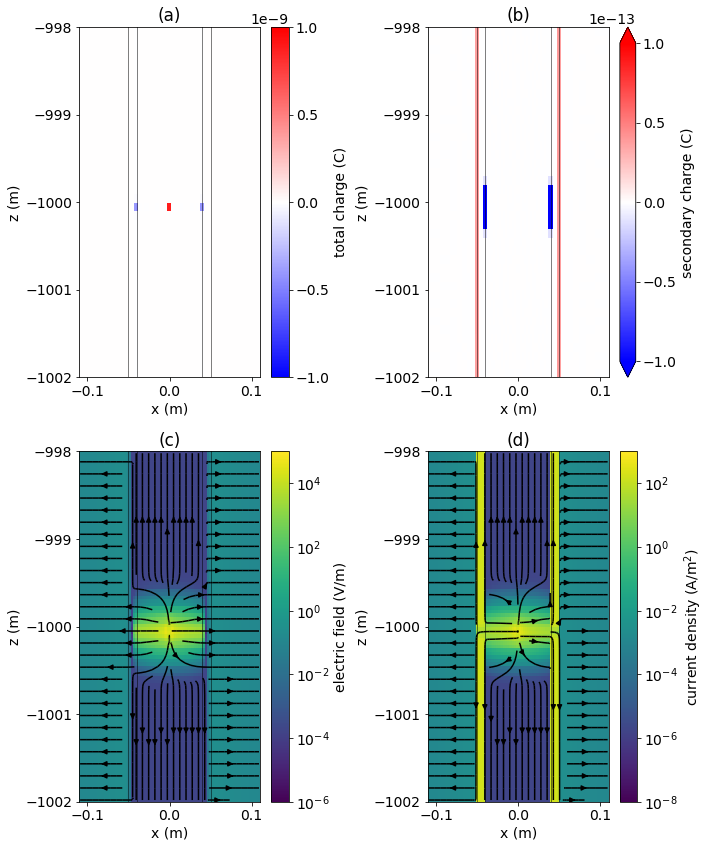

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(2*5, 2*6))
ax=ax.flatten()

max_r = 0.11
min_depth = 998
max_depth = 1002

# model = 
xlim = max_r * np.r_[-1, 1]
zlim = np.r_[-max_depth, -min_depth]

def plotme(a, view, clim, **kwargs):
    out = viewer.plot_cross_section(
        ax=a, model_key='casing', xlim=xlim, zlim=zlim, clim=clim,
        view=view, **kwargs    
    )
    a.set_xlabel('x (m)')
    a.set_ylabel('z (m)')
    
    cb = out[-1]
    if view == 'charge':    
        cb.set_ticks(np.linspace(clim[0], clim[1], 5))
    else:
        ticks = 10**np.hstack([np.arange(np.log10(clim[0]), np.log10(clim[1])), np.r_[np.log10(clim[1])]])[::2]
        cb.set_ticks(ticks)
#     out[-1].set_clim(clim)
    return out

# total charges
clim = 1e-9* np.r_[-1, 1]
out = plotme(ax[0], 'charge', clim)
out[-1].set_label('total charge (C)')
ax[0].set_title('(a)')

# secondary charges
clim = 1e-13 * np.r_[-1, 1]
out = plotme(ax[1], 'charge', clim, cb_extend="both", prim_sec="secondary")
ax[1].set_title('(b)')
out[-1].set_label('secondary charge (C)')

# electric field
clim = np.r_[1e-6, 1e5]
out = plotme(ax[2], 'e', clim)
ax[2].set_title('(c)')
out[-1].set_label('electric field (V/m)')

# # current density
clim = np.r_[1e-8, 1e3]
out = plotme(ax[3], 'j', clim)
ax[3].set_title('(d)')
out[-1].set_label('current density (A/m$^2$)')


[a.set_yticks(np.hstack([np.arange(-max_depth, -min_depth),np.r_[-min_depth]])) for a in ax]

plt.tight_layout()

Uncomment to save the figure

In [22]:
# fig.savefig('kaufman_zones', dpi=350, bbox_inches="tight")